In [1]:
import os,sys
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from jellyfish import damerau_levenshtein_distance
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader
sys.path.append(os.path.abspath(".."))
from neural_network.HistoryDataset import CustomDataset
from neural_network.llamp_multiout import BertMultiOutputClassificationHeads
from preprocessing.log_to_history import Log

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
csv_log = "helpdesk"
TYPE = "all"

semantic_dir = "../semantic_data"
models_dir = "../models"

model_name = "prajjwal1/bert-medium"
MAX_LEN = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device ->", device)

device -> cuda


In [3]:
def load_pickle(path: str):
    with open(path, "rb") as f:
        return pickle.load(f)

def clean_sequence(sequence_str, label2id):
    sequence_list = sequence_str.split(" ")
    end_activity_str = str(label2id["activity"]["ENDactivity"])
    if end_activity_str in sequence_list:
        first_end_index = sequence_list.index(end_activity_str)
        sequence_list = sequence_list[: first_end_index + 1]
    return " ".join(sequence_list)

def remove_word(sentence, word):
    words = sentence.split()
    words = [w for w in words if w != word]
    return " ".join(words)

def pad_list_to_length(seq, target_length, end_id):
    if target_length <= 0:
        return seq
    if len(seq) == 0:
        return [0] * target_length
    if len(seq) < target_length:
        return seq + [end_id] * (target_length - len(seq))
    if len(seq) > target_length:
        return seq[:target_length]
    return seq

def extract_prefix(full_trace, suffix_sequence):
    pad_token = suffix_sequence[-1]
    if pad_token in full_trace:
        effective_full = full_trace[: full_trace.index(pad_token)]
    else:
        effective_full = full_trace

    if pad_token in suffix_sequence:
        effective_suffix = suffix_sequence[: suffix_sequence.index(pad_token)]
    else:
        effective_suffix = suffix_sequence

    prefix_length = len(effective_full) - len(effective_suffix)
    return full_trace[:prefix_length]

In [4]:
def predict_suffix_no_freq(model_output):
    predicted = []
    for i in range(len(model_output)):
        pred = model_output[i].argmax(dim=1).cpu().numpy()
        predicted.append(str(pred[0]))
    return predicted

def predict_suffix_with_freq_consistent(model_output, prefix_sequence, trace_frequencies, label2id, beta, threshold):
    # fixed padding length from db
    if len(trace_frequencies) == 0:
        max_len_in_db = 0
    else:
        max_len_in_db = max(len(k) for k in trace_frequencies.keys())

    end_id = label2id["activity"]["ENDactivity"]

    # 1) model suffix (CONSISTENT with no-freq)
    model_suffix_full = predict_suffix_no_freq(model_output)
    model_suffix_cut = clean_sequence(" ".join(model_suffix_full), label2id).split()

    # build candidate trace WITHOUT trailing END
    if len(model_suffix_cut) > 0 and model_suffix_cut[-1] == str(end_id):
        model_suffix_for_trace = model_suffix_cut[:-1]
    else:
        model_suffix_for_trace = model_suffix_cut

    prefix_ints = [int(x) for x in prefix_sequence]
    suffix_ints = [int(x) for x in model_suffix_for_trace]
    candidate_trace = prefix_ints + suffix_ints

    # 2) pad candidate before exact match
    padded_candidate = pad_list_to_length(candidate_trace, max_len_in_db, end_id)
    candidate_tuple = tuple(padded_candidate)

    # 3) exact match
    if candidate_tuple in trace_frequencies:
        return model_suffix_cut

    # 4) best match by DL similarity + frequency
    if len(trace_frequencies) == 0 or max_len_in_db == 0:
        return model_suffix_cut

    best_trace = None
    best_similarity = -1.0
    best_freq = -1.0
    best_tau = -1.0

    candidate_str = " ".join(map(str, padded_candidate))
    f_max = max(trace_frequencies.values())

    for hist_trace, freq in trace_frequencies.items():
        hist_list = list(hist_trace)
        padded_hist = pad_list_to_length(hist_list, max_len_in_db, end_id)
        hist_str = " ".join(map(str, padded_hist))

        dl_dist = damerau_levenshtein_distance(candidate_str, hist_str)
        similarity = max(0.0, 1.0 - (dl_dist / max_len_in_db))
        tau = beta * similarity + (1.0 - beta) * (freq / f_max)

        if (
            tau > best_tau
            or (tau == best_tau and similarity > best_similarity)
            or (tau == best_tau and similarity == best_similarity and freq > best_freq)
        ):
            best_tau = tau
            best_similarity = similarity
            best_freq = freq
            best_trace = hist_list

    if best_similarity >= threshold and best_trace is not None and len(best_trace) > len(prefix_ints):
        override_suffix_int = best_trace[len(prefix_ints):]
        return list(map(str, override_suffix_int))

    return model_suffix_cut

In [5]:
#Log(csv_log, TYPE)

In [6]:
base = os.path.join(semantic_dir, csv_log)

test = load_pickle(os.path.join(base, f"{csv_log}_test_{TYPE}.pkl"))
id2label = load_pickle(os.path.join(base, f"{csv_log}_id2label_{TYPE}.pkl"))
label2id = load_pickle(os.path.join(base, f"{csv_log}_label2id_{TYPE}.pkl"))

y_train_suffix = load_pickle(os.path.join(base, f"{csv_log}_suffix_train_{TYPE}.pkl"))
y_test_prefix = load_pickle(os.path.join(base, f"{csv_log}_prefixes_test_{TYPE}.pkl"))
y_test_suffix = load_pickle(os.path.join(base, f"{csv_log}_suffix_test_{TYPE}.pkl"))
y_test_activities = load_pickle(os.path.join(base, f"{csv_log}_activities_test_{TYPE}.pkl"))
trace_frequencies = load_pickle(os.path.join(base, f"{csv_log}_encoded_trace_frequencies_{TYPE}.pkl"))

tokenizer = AutoTokenizer.from_pretrained(model_name, truncation_side="left")
backbone = AutoModel.from_pretrained(model_name)

output_sizes = [len(id2label["activity"]) for _ in range(len(y_train_suffix))]
model = BertMultiOutputClassificationHeads(backbone, output_sizes)

model_path = os.path.join(models_dir, f"{csv_log}_{TYPE}.pth")
state = torch.load(model_path, map_location="cpu")
model.load_state_dict(state)
model = model.to(device)
model.eval()

test_dataset = CustomDataset(test, y_test_suffix, y_test_prefix, y_test_activities, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Loaded model:", model_path)
print("Test size:", len(test_dataset))

Loaded model: ../models/helpdesk_all.pth
Test size: 7155


In [7]:
betas = np.arange(0.1, 1.0, 0.1)       # 0.1..0.9
thresholds = np.arange(0.1, 1.0, 0.1)  # 0.1..0.9

heat = np.zeros((len(betas), len(thresholds)), dtype=np.float32)

end_token = str(label2id["activity"]["ENDactivity"])

with torch.no_grad():
    for bi, beta in enumerate(betas):
        for ti, threshold in enumerate(thresholds):
            list_dl_distance_with_freq = []

            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                output = model(input_ids, attention_mask)

                true_sequence = []
                full_trace = []
                for i in range(len(batch["labels"])):
                    true_sequence.append(str(batch["labels"][i].item()))
                    full_trace.append(str(batch["activities"][i].item()))

                prefix_sequence = extract_prefix(full_trace, true_sequence)

                predicted_with_freq = predict_suffix_with_freq_consistent(
                    model_output=output,
                    prefix_sequence=prefix_sequence,
                    trace_frequencies=trace_frequencies,
                    label2id=label2id,
                    beta=float(beta),
                    threshold=float(threshold),
                )

                seq_pred_with_freq = clean_sequence(" ".join(predicted_with_freq), label2id)
                seq_true = clean_sequence(" ".join(map(str, true_sequence)), label2id)

                seq_pred_with_freq = remove_word(seq_pred_with_freq, end_token)
                seq_true = remove_word(seq_true, end_token)

                if seq_pred_with_freq == "" and seq_true == "":
                    seq_pred_with_freq = "end"
                    seq_true = "end"
                if seq_pred_with_freq == "":
                    seq_pred_with_freq = "end"

                dl_distance_with_freq = 1 - (
                    damerau_levenshtein_distance(seq_pred_with_freq, seq_true)
                    / max(len(seq_pred_with_freq), len(seq_true))
                )

                list_dl_distance_with_freq.append(dl_distance_with_freq)

            heat[bi, ti] = float(np.mean(list_dl_distance_with_freq))
            print(f"beta={beta:.1f}, threshold={threshold:.1f} -> mean DL={heat[bi, ti]:.4f}")

beta=0.1, threshold=0.1 -> mean DL=0.8576
beta=0.1, threshold=0.2 -> mean DL=0.8573
beta=0.1, threshold=0.3 -> mean DL=0.8575
beta=0.1, threshold=0.4 -> mean DL=0.8577
beta=0.1, threshold=0.5 -> mean DL=0.8580
beta=0.1, threshold=0.6 -> mean DL=0.8584
beta=0.1, threshold=0.7 -> mean DL=0.8580
beta=0.1, threshold=0.8 -> mean DL=0.8581
beta=0.1, threshold=0.9 -> mean DL=0.8568
beta=0.2, threshold=0.1 -> mean DL=0.8576
beta=0.2, threshold=0.2 -> mean DL=0.8573
beta=0.2, threshold=0.3 -> mean DL=0.8575
beta=0.2, threshold=0.4 -> mean DL=0.8577
beta=0.2, threshold=0.5 -> mean DL=0.8580
beta=0.2, threshold=0.6 -> mean DL=0.8584
beta=0.2, threshold=0.7 -> mean DL=0.8580
beta=0.2, threshold=0.8 -> mean DL=0.8581
beta=0.2, threshold=0.9 -> mean DL=0.8568
beta=0.3, threshold=0.1 -> mean DL=0.8576
beta=0.3, threshold=0.2 -> mean DL=0.8573
beta=0.3, threshold=0.3 -> mean DL=0.8575
beta=0.3, threshold=0.4 -> mean DL=0.8577
beta=0.3, threshold=0.5 -> mean DL=0.8580
beta=0.3, threshold=0.6 -> mean DL

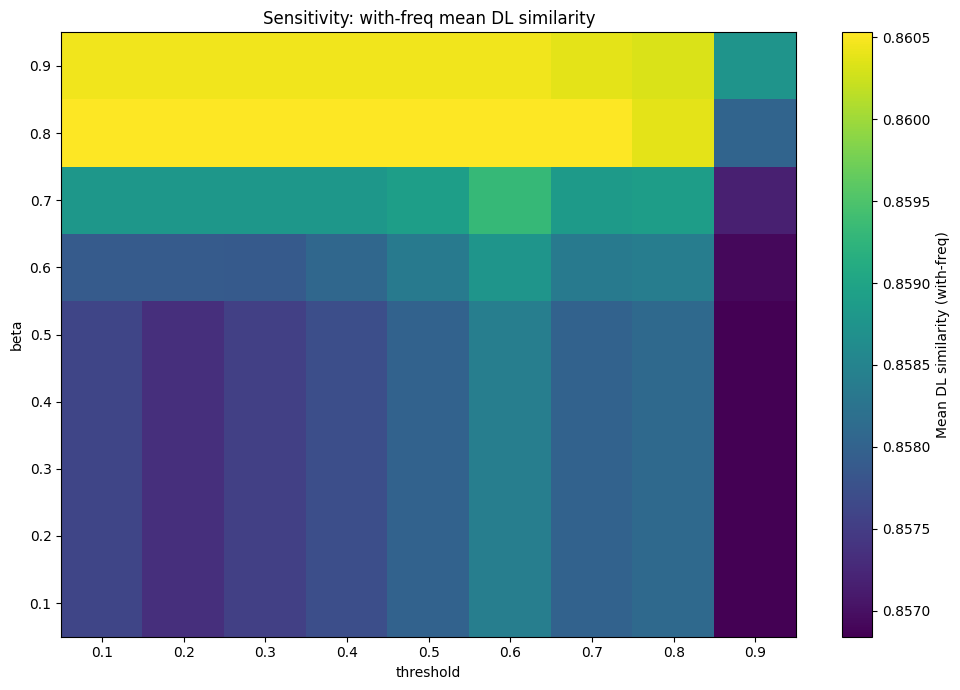

In [8]:
plt.figure(figsize=(10, 7))
im = plt.imshow(heat, aspect="auto", origin="lower")  # default colormap
plt.colorbar(im, label="Mean DL similarity (with-freq)")

plt.xticks(range(len(thresholds)), [f"{x:.1f}" for x in thresholds])
plt.yticks(range(len(betas)), [f"{x:.1f}" for x in betas])

plt.xlabel("threshold")
plt.ylabel("beta")
plt.title("Sensitivity: with-freq mean DL similarity")

plt.tight_layout()
plt.show()